# <center> **ASSIGNMENT 3** <center>
### Group 9

| **Name**               | **Roll No.** | **Percentage of Contribution**  |
|------------------------|--------------|---------------------------------|
| Gauravshankar Mishra   | 23510039     | 25%                             |
| Dinesh Patel           | 23510032     | 25%                             |
| Dipak Kumar            | 23510033     | 25%                             |
| Dharam Dev             | 23510031     | 25%                             |

## Problem 1
**a) Use a five-point stencil for the second derivative $ \frac{\partial^2 \psi(x, t)}{\partial x^2} $ of the waveform (with respect to the spatial coordinate).**

**b) Calculate the matrix A as given in Eqn. 8.9 of Wang’s textbook.** 

**c) Solve the system of first-order differential equations given in Eqn. 8.10 of Wang’s book to
evolve the initial wavepacket using the Space-Discretized Leapfrog (SDLF) method as
outlined in Eqn. 8.12. Use the same algorithm and notation in your code. Verify that the
norm of the wavepacket  $ R^T R + I^T I $  is constant.**

**d) Use this modified code to study the time evolution of a normalised Gaussian wavepacket in a
harmonic potential well $ V(x) = \frac{1}{2} x^2 $ . Choose the same parameters as in Section 8.2.3 of Wang’s book.**

**e) Show the real and imaginary parts, R(x, t) and I(x, t) respectively, of the wave function at three
positions (left end, centre, and right end), as shown in Figure 8.2.**

**f) Calculate and plot the position expectation value $〈x〉$ and the peak value of the probability
density function $ |ψ(x, t)|^2 $ as a function of time, as shown in Figure 8.4. Comment on the features of this plot.**

**g) Numerically confirm Eqn. 8.19,**

**$ m\frac{\partial^2 〈x〉}{\partial t^2} = \frac{d〈p〉}{dt} = -〈\frac{\partial V}{\partial x}〉 $**

## Time-Domain Schrodinger equation (TDSE)

In atomic units (a.u.) , the time domain schrodinger equation in 1D is given by

$$
i \, \frac{\partial \psi(x, t)}{\partial t}
= -\frac{1}{2} \frac{\partial^2 \psi(x, t)}{\partial x^2} + V(x, t) \; \psi(x, t)
$$

Note that:
* all distances $x$ are now in units of the Bohr radius $a_0 = 5.29\times 10^{-11} \; \text{m}$
* all energies (kinetic, potential, etc.) are in units of $E_0 = 27.2 \; \text{eV}$
* time $t$ is in units of $\hbar/E_0 = 2.42 \times 10^{-17} \; \text{s}$

#### The problem

Time-evolution of a wavepacket: Given the 'initial' wavefunction $\psi(x, t=0)$ at all $a \leq x \leq b$ describing a quantum mechanical system prepared at $t=0$, we would like to know $\psi(x, t)$ at later times $t > 0$. 

#### Reducing the TDSE to Initial Value Problem

We discretize the spatial domain $a \leq x \leq b$ to a uniform grid of $N$ points: $(a, a+\Delta x,a+2\Delta x, \cdots, x_{j-1}, x_j, x_{j+1}, \cdots, b-2\Delta x, b-\Delta x, b]$.

At any given grid point $x_j$ in space, we can use the finite difference to approximately calculate the second-order differential operator $\frac{\partial^2 \psi(x, t)}{\partial x^2} |_{x_j}$ on the RHS of the TDSE:

$$
\frac{\partial^2 \psi(x_j, t)}{\partial x^2} \approx \frac{-\psi(x_j-2\Delta x, t) + 16\psi(x_j-\Delta x, t) - 30\psi(x_j, t) + 16\psi(x_j+\Delta x, t) - \psi(x_j+2\Delta x, t)}{12\Delta x^2}
$$

Further compacting the notation by denoting $\psi(x_j, t) \rightarrow \psi_j(t)$, the TDSE can be written down as a system of $N$ ODEs:
$$
\frac{\partial \psi_j(t)}{\partial t} =-\frac{i}{24 \Delta x^2} \left [-\psi_{j-2}(t) + 16\psi_{j-1}(t) - 30\psi_{j}(t) + 16\psi_{j+1}(t) - \psi_{j+2}(t)\right ] + V_j(t) \; \psi_j(t)
$$


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from tqdm import tqdm
from matplotlib import animation

%matplotlib inline

In [2]:
xa = -10
xb = 10

dx = 0.04
x = np.arange(xa, xb+dx, dx)
Vx = (1/2)*x**2

n= len(x)
def five_point_stencil(n, dx):
    # Initialize the matrix
    matrix = np.zeros((n, n))

    # Fill the matrix
    for i in range(n):
        matrix[i, i] = -(30/(24*dx**2)+Vx[i])
        if i-2 >= 0:
            matrix[i, i-2] = -1/(24*dx**2)
        if i-1 >= 0:
            matrix[i, i-1] = 16/(24*dx**2)

        if i+1 < n:
            matrix[i, i+1] = 16/(24*dx**2)
        if i+2 < n:
            matrix[i, i+2] = -1/(24*dx**2)

    return matrix

# Test the function
# Number of grid points
dx = 0.04 # Grid spacing
matrix = -five_point_stencil(n, dx)
print(matrix)
A = matrix
print(len(A[0]))

[[ 831.25       -416.66666667   26.04166667 ...   -0.
    -0.           -0.        ]
 [-416.66666667  830.8508     -416.66666667 ...   -0.
    -0.           -0.        ]
 [  26.04166667 -416.66666667  830.4532     ...   -0.
    -0.           -0.        ]
 ...
 [  -0.           -0.           -0.         ...  830.4532
  -416.66666667   26.04166667]
 [  -0.           -0.           -0.         ... -416.66666667
   830.8508     -416.66666667]
 [  -0.           -0.           -0.         ...   26.04166667
  -416.66666667  831.25      ]]
501


**Matrix A**

So, we have got the matrix A which is a pentadiaogonal matrix, when we used the five point stencil for the secind order derivative.
The matrix is made up of central diagonal elements as $ a_j = \frac{30}{24\Delta x^2}+V_j  $, upper and lower diagonal elements as $ b = -\frac{16}{24\Delta x^2} $ and similarly , $ c = \frac{1}{24\Delta x^2} $

Matrix A will be as follows:


\begin{bmatrix}
a_0 & b & c & 0 & 0 & 0 \\
b & a_1 & b & c & 0 & 0 \\
c & b & a_2 & b & c & 0 \\
0 & c & b & a_4 & b & c \\
0 & 0 & c & b & a_5 & b \\
0 & 0 & 0 & c & b & a_6 \\
\end{bmatrix}



#### Integrating the set of ODEs

We need to consider that the TDSE preserves the normalization of the wavefunction. so an ODE solver that preserves the norm should be used. The Leapfrog method has this special property.

To make it suitable for leapfroG integration, we need to separate the wavefunction $\psi_j(t)$ into its real and imaginary parts:
$$
\psi_j(t) = R_j(t) + i \, I_j(t).
$$

Substituion leads to the following set of coupled ODEs:
\begin{eqnarray}
\frac{dR_j}{dt} &=& \frac{1}{24\Delta x^2}I_{j-2} -\frac{16}{24\Delta x^2}I_{j-1} + \left ( \frac{30}{24\Delta x^2} + V_j \right ) I_j - \frac{16}{24\Delta x^2}I_{j+1} + \frac{1}{24\Delta x^2}I_{j+2} \\
\frac{dI_j}{dt} &=& -\frac{1}{24\Delta x^2}R_{j-2} + \frac{16}{24\Delta x^2}R_{j-1} - \left ( \frac{30}{24\Delta x^2} + V_j \right ) R_j + \frac{16}{24\Delta x^2}R_{j+1} - \frac{1}{24\Delta x^2}R_{j+2} \\           
\end{eqnarray}

As discussed in class, the above set of coupled ODEs can be compared to the set of differential equations for a Hamiltonian system and one can think of $R_j$'s as 'generalized coordinates', and $I_j$'s as the 'generalized velocities'. As such, by the same analogy, $R^T R + I^T I$ must be preserved at all times. In fact this is integrand of the wavefunction normalization!

#### Leap-Frog Integration

\begin{eqnarray}
I_j {(t + \Delta t/2)} &=& I_j (t) + \left [ {dI_j}/{dt} \right ]_{R_j(t)} \times \Delta t/2  \\
R_j {(t + \Delta t)} &=& R_j (t) + \left [ dR_j/dt \right ]_{I_j{(t + \Delta t/2)}} \times \Delta t \\
I_j {(t + \Delta t)} &=& I_j {(t + \Delta t/2)} + \left [ dI/dt \right ]_{R_j(t + \Delta t)} \times \Delta t/2
\end{eqnarray}




In [3]:
a = np.array([0,1,2,3,4,5])
print (a)
print (np.roll(a, 1))
print (np.roll(a, -1))

[0 1 2 3 4 5]
[5 0 1 2 3 4]
[1 2 3 4 5 0]


In [4]:
def dRdt(I, Vx, dx):
    # Calculate and return dR/dt at all x_j (assume periodic bndry for wavefunction)
    b = 1.0/(24.0*dx**2.)

    dydt = b*np.roll(I, 2)
    dydt += -16*b*np.roll(I, 1)
    dydt += (30*b + Vx)*I
    dydt += -16*b*np.roll(I, -1)
    dydt += b*np.roll(I, -2)

    return dydt

In [5]:
def dIdt(R, Vx, dx):
    # Calculate and return dI/dt at all x_j (assume periodic bndry for wavefunction)
    b = 1.0/(24.0*dx**2.)

    dydt = -b*np.roll(R, 2)
    dydt += 16*b*np.roll(R, 1)
    dydt += -(30*b + Vx)*R
    dydt += 16*b*np.roll(R, -1)
    dydt += -b*np.roll(R, -2)

    return dydt


In [6]:
#-- position expectation value.
def avg_x(x, psi):
    dx = x[1]-x[0]
    xPsi = x*psi
    return np.real(integrate.simps(psi.conjugate()* xPsi, x))


In [7]:
# Momentum expectation value 
def avg_P(x, R, I):
    # Can be shown that: <p> = \hbar \int (RI' - IR') dx
    dx = x[1] - x[0]

    #-- 5-point stencil for derivatives (assume periodic bndry for wavefunction)
    dRdx = (1.0/(12.0*dx))*(np.roll(R, -2) - 8*np.roll(R, -1) + 8*np.roll(R, 1) - np.roll(R, 2))
    dIdx = (1.0/(12.0*dx))*(np.roll(I, -2) - 8*np.roll(I, -1) + 8*np.roll(I, 1) - np.roll(I, 2))

    return (integrate.simps(R*dIdx - I*dRdx, x))


#### Harmonic potential Well

In [8]:
@np.vectorize
#-- cliff potential at x=1.0
def V(x):
    if -10<= x <= 10:
        return (1/2)*x**2
    else:
        return 0

#### Initial wavepacket at t=0

$$
\psi(x, t=0) = \left ( \frac{1}{\sigma \sqrt{\pi}} \right )^{1/2} \exp \left [ -(x-x_0)^2 / 2\sigma^2 + i k_0 x \right ]
$$


In [9]:
# Initial conditions from Wang's Book 
xa = -10
xb = 10

#-- wavefunction at t=0
sigma = 0.5
x0 = -3
k0 = 0

dx = 0.04
x = np.arange(xa, xb+dx, dx)
print (len(x))
Vx = V(x)

psi0 = 1./np.sqrt(sigma * np.sqrt(np.pi))* np.exp( -((x-x0)**2.)/(2.*sigma**2.) + 1j*k0*x )
R = np.real(psi0)
I = np.imag(psi0)

print('At t=0, dx = %.6e, k0 = %.2f, <p> = %.3f, <x> = %.2f'%
      (dx, k0, avg_P(x, R, I), avg_x(x, psi0) ))

501
At t=0, dx = 4.000000e-02, k0 = 0.00, <p> = 0.000, <x> = -3.00


### Plot the initial wave packet

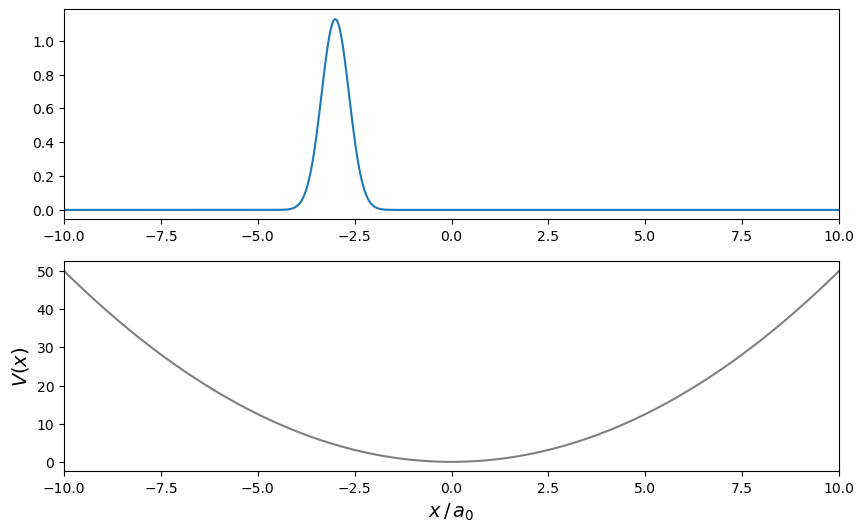

In [10]:
plt.figure(figsize=(10,6))

plt.subplot(2,1,1)
plt.plot(x, np.abs(psi0)**2)
plt.xlim(xa, xb)

plt.subplot(2,1,2)
plt.plot(x, V(x), '-', color='gray')
plt.xlabel(r'$x \, / \, a_0$', fontsize=14)
plt.ylabel(r'$V(x)$', fontsize=14)

plt.xlim(xa, xb)
plt.show()

#### Leap-frog integration

In [11]:
dt = 0.5*(dx**2)
Nt =  25000      # time-steps to integrate over
print('dx = %.4e, dt = %.4e, integrating for %d time=steps'%(dx, dt, Nt))
from numpy import transpose
tfrac = 0.04
Nplots = int(1./tfrac)
print(Nplots)
psi_t = np.empty((Nplots, len(x)), dtype='complex')
Norm_Matrix= []
Time = [0]
R_part=[]
I_part=[]
j = 0
for i in range(1, Nt+1):

    I_half = I - np.dot(A,R) * (dt/2.)  #-- I(t + delta_t/2)
    R = R + np.dot(A,I_half) * dt       #-- R(t + delta_t)
    I = I_half - np.dot(A,R) * (dt/2.)  #-- I(t + delta_t)
    R_part.append(R)
    I_part.append(I)
    Time.append(i*dt)
    Norm_Matrix.append(np.dot(R,transpose(R)) + np.dot(I,transpose(I)))
    
    if ((i % int(tfrac*Nt)) == 0):
        print('Storing snapshot %2d/%2d of the complex wavefunction '%(j+1, Nplots))
        psi_t[j,:] = R + 1j*I
        print(np.dot(R,transpose(R)) + np.dot(I,transpose(I)))
        j = j+1 #-- prepare for next snapshot
# print(R_part)

dx = 4.0000e-02, dt = 8.0000e-04, integrating for 25000 time=steps
25
Storing snapshot  1/25 of the complex wavefunction 
24.99992538754762
Storing snapshot  2/25 of the complex wavefunction 
24.999932351639202
Storing snapshot  3/25 of the complex wavefunction 
24.9999474271421
Storing snapshot  4/25 of the complex wavefunction 
24.99988561220042
Storing snapshot  5/25 of the complex wavefunction 
24.99992894675487
Storing snapshot  6/25 of the complex wavefunction 
24.999932351639448
Storing snapshot  7/25 of the complex wavefunction 
24.999921687936464
Storing snapshot  8/25 of the complex wavefunction 
24.9999355032419
Storing snapshot  9/25 of the complex wavefunction 
24.999937732027647
Storing snapshot 10/25 of the complex wavefunction 
24.999932351638854
Storing snapshot 11/25 of the complex wavefunction 
24.999927321072423
Storing snapshot 12/25 of the complex wavefunction 
24.99996456820731
Storing snapshot 13/25 of the complex wavefunction 
24.999931437978937
Storing snapsho

**Norm of the wavepacket  $ R^T R + I^T I $  is constant.**

Hence, $ \frac{d}{dt} (R^T R + I^T I) = 0 $ , which is a statement of conservation of probability.

Also, we can see $R^T R + I^T I$ as a genersl energy and hence it agrees conservation of energy in a Hamiltonian system.

Norm Of the The Wave function is Conserved as it fluctuates in very small range ie. 0.00001 order

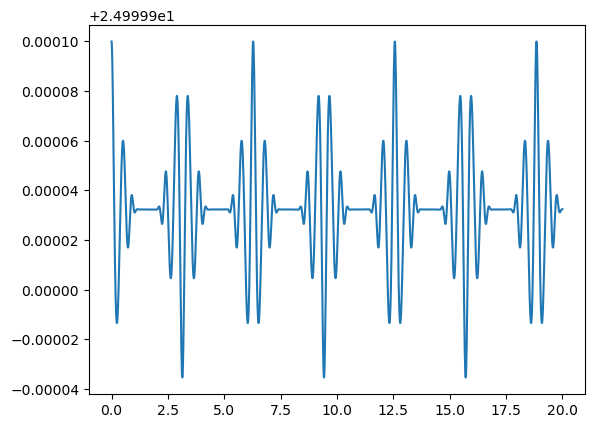

In [12]:
plt.plot(Time[:-1],Norm_Matrix)

### Time Evolution Of the Wavepacket

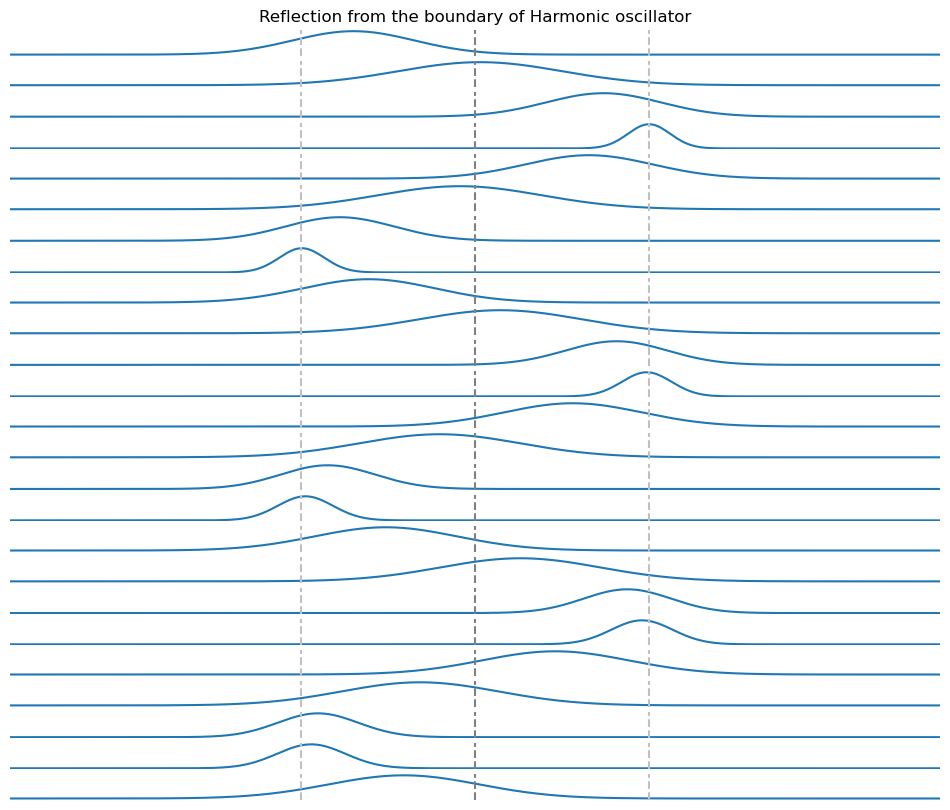

In [13]:
#-- Plot the wavefunctions psi(x, t) recorded at different instances
plt.figure(figsize=(12,10))

for j in range(Nplots):
    ax = plt.subplot(Nplots, 1, j+1)

    #-- remove all axis
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    for spine in ['top', 'right', 'left', 'bottom']:
        ax.spines[spine].set_visible(False)
    ax.set_ylim(-0.02, 1.05*np.max(np.abs(psi_t[j,:])**2))
    ax.set_xlim(-8,8)
    #-- set the title for the first subplot
    if (j==0):
        plt.title('Reflection from the boundary of Harmonic oscillator')

#     -- plot |psi(t)|^2
    ax.plot(x, np.abs(psi_t[j,:])**2)
    #-- mark the position of the cliff
    ax.axvline(0.0, ls='--', color='gray')
    ax.axvline(-3, ls='--', color='silver')
    ax.axvline(3, ls='--', color='silver')


plt.show()

From the time evolution of Normalised Gaussian Wavefunction in a Harmonic Potential, we can see that the wavepacket moves to the right, accelerates and broadens as it approaches the center. Past the center, it starts to slow down and becomes narrower until the right end point where the wavepacket looks nearly identical to the original one (refocusing). Afterward, it reverses direction, and moves toward the starting position.






### For Norm of the Wavepacket.

In [14]:
#-- add psi0 to the top of the stack of \psi(t)
# Initialize empty lists to store expectation values
avgX_values = []
avgP_values = []
# Add psi0 to the top of the stack of \psi(t)
psi_t = np.vstack((psi0, psi_t))

for j in range(len(psi_t)):
    norm = integrate.simps(np.abs(psi_t[j,:])**2, x)
    avgX = avg_x(x, np.real(psi_t[j,:]) + 1j*np.imag(psi_t[j,:]))
    avgP = avg_P(x, np.real(psi_t[j,:]), np.imag(psi_t[j,:]))
    # Store expectation values
    avgX_values.append(avgX)
    avgP_values.append(avgP)

    print ('%2d \t norm = %.2e <x> = %.3e, <p> = %4.2f'%(j+1, norm, avgX, avgP))


 1 	 norm = 1.00e+00 <x> = -3.000e+00, <p> = 0.00
 2 	 norm = 1.00e+00 <x> = -2.090e+00, <p> = -2.15
 3 	 norm = 1.00e+00 <x> = 8.759e-02, <p> = -3.00
 4 	 norm = 1.00e+00 <x> = 2.212e+00, <p> = -2.03
 5 	 norm = 1.00e+00 <x> = 2.995e+00, <p> = 0.18
 6 	 norm = 1.00e+00 <x> = 1.961e+00, <p> = 2.27
 7 	 norm = 1.00e+00 <x> = -2.625e-01, <p> = 2.99
 8 	 norm = 1.00e+00 <x> = -2.327e+00, <p> = 1.89
 9 	 norm = 1.00e+00 <x> = -2.980e+00, <p> = -0.35
10 	 norm = 1.00e+00 <x> = -1.825e+00, <p> = -2.38
11 	 norm = 1.00e+00 <x> = 4.365e-01, <p> = -2.97
12 	 norm = 1.00e+00 <x> = 2.433e+00, <p> = -1.75
13 	 norm = 1.00e+00 <x> = 2.954e+00, <p> = 0.52
14 	 norm = 1.00e+00 <x> = 1.683e+00, <p> = 2.48
15 	 norm = 1.00e+00 <x> = -6.090e-01, <p> = 2.94
16 	 norm = 1.00e+00 <x> = -2.532e+00, <p> = 1.61
17 	 norm = 1.00e+00 <x> = -2.918e+00, <p> = -0.69
18 	 norm = 1.00e+00 <x> = -1.535e+00, <p> = -2.58
19 	 norm = 1.00e+00 <x> = 7.794e-01, <p> = -2.90
20 	 norm = 1.00e+00 <x> = 2.621e+00, <p> = -1.46

Animation for wave function

MovieWriter Pillow unavailable; using Pillow instead.


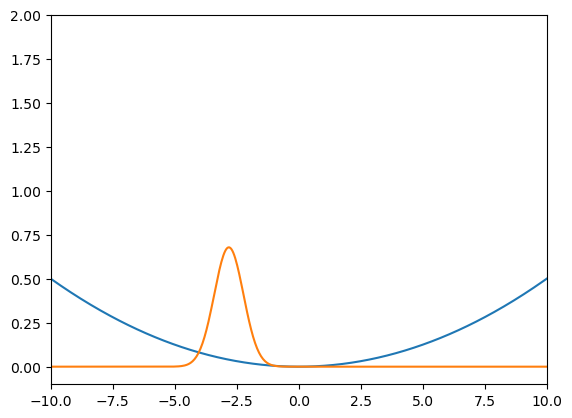

In [15]:
fig, ax = plt.subplots()
ax.set_xlim(-10,10)
ax.plot(x,V(x)/100)
line, = ax.plot(x, 10*np.abs(psi_t[0,:])**2)

def update(frame):
    ax.set_ylim(-0.1, 2)
    line.set_ydata(np.abs(psi_t[frame,:])**2)
    return line,

ani = animation.FuncAnimation(fig, update, frames=Nplots, interval=100, blit=True)

ani.save('wave_function_evolution.gif', writer='Pillow')

plt.show()


### Plotation For Probability , Real and Imagionary part of wave function

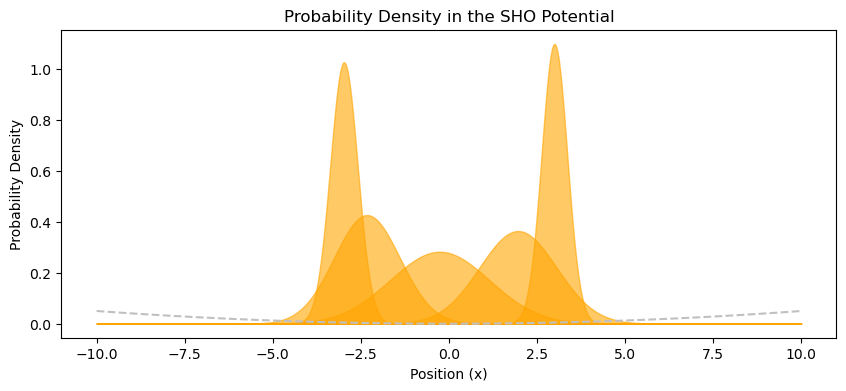

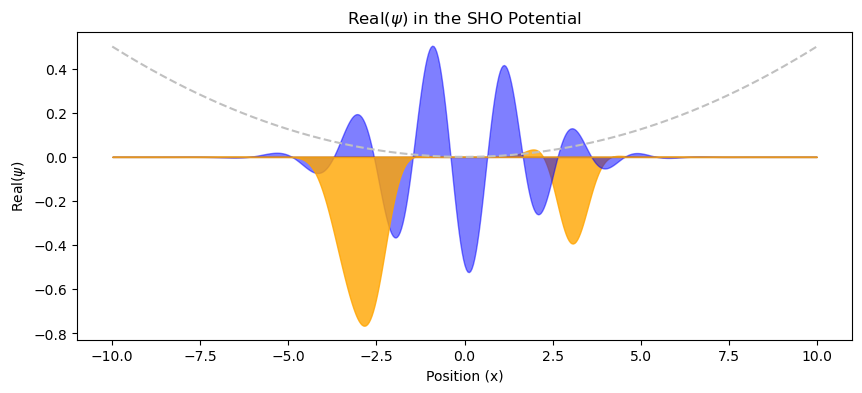

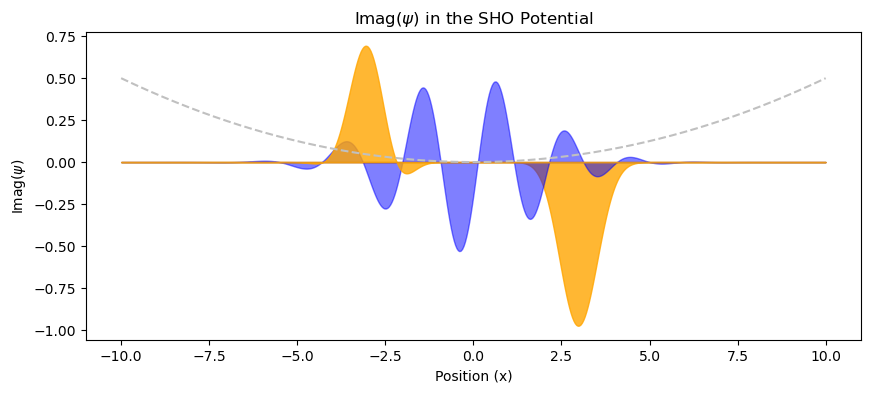

In [16]:
plt.figure(figsize=(10,4))
plt.plot(x,V(x)/1e3 , ls = "--" , color ='silver')
plt.fill_between(x, 0, np.abs(psi_t[4])**2, color='orange', alpha=0.6)
plt.fill_between(x, 0, np.abs(psi_t[5])**2, color='orange', alpha=0.6)
plt.fill_between(x, 0, np.abs(psi_t[6])**2, color='orange', alpha=0.6)
plt.fill_between(x, 0, np.abs(psi_t[7])**2, color='orange', alpha=0.6)
plt.fill_between(x, 0, np.abs(psi_t[8])**2, color='orange', alpha=0.6)
plt.xlabel('Position (x)')
plt.ylabel('Probability Density')
plt.title('Probability Density in the SHO Potential')
plt.show()

plt.figure(figsize=(10,4))
plt.plot(x,V(x)/1e2 , ls = "--" , color ='silver')
plt.fill_between(x, 0, np.real(psi_t[4]), color='orange',alpha=0.8)
# plt.fill_between(x, 0, np.real(psi_t[5]), color='blue', alpha=0.5)
plt.fill_between(x, 0, np.real(psi_t[6]), color='blue', alpha=0.5)
# plt.fill_between(x, 0, np.real(psi_t[7]), color='blue', alpha=0.5)
plt.fill_between(x, 0, np.real(psi_t[8]), color='Orange', alpha=0.8)
plt.xlabel('Position (x)')
plt.xlabel('Position (x)')
plt.ylabel('Real($\psi$)')
plt.title('Real($\psi$) in the SHO Potential')
plt.show()

plt.figure(figsize=(10,4))
plt.plot(x,V(x)/1e2 , ls = "--" , color ='silver')
plt.fill_between(x, 0, np.imag(psi_t[4]), color='orange',alpha=0.8)
# plt.fill_between(x, 0, np.imag(psi_t[5]), color='blue', alpha=0.5)
plt.fill_between(x, 0, np.imag(psi_t[6]), color='blue', alpha=0.5)
# plt.fill_between(x, 0, np.imag(psi_t[7]), color='blue', alpha=0.5)
plt.fill_between(x, 0, np.imag(psi_t[8]), color='Orange', alpha=0.8)
plt.xlabel('Position (x)')
plt.ylabel('Imag($\psi$)')
# plt.xticks(-7.5,7.5)
plt.title('Imag($\psi$) in the SHO Potential')
plt.show()


The top graph shows the probability distribution at five locations. The potential is also drawn for easy reference. The wavepacket moves to the right, accelerates and broadens as it approaches the center. Past
the center, it starts to slow down and becomes narrower until the right end point where the wavepacket looks nearly identical to the original one (refocusing). Afterward, it reverses direction, and moves toward the starting position.

The middle and bottom graphs shows the real and imaginary parts, R and I respectively, of the wave function at three positions (left end, center, and right end). Initially, there is only the real part. With increasing t, both parts develop, and become more oscillatory toward the center. The peaks of R and the nodes of I coincide with each other (vice versa), making the probability density smooth throughout. Surprisingly, the real part does not vanish at the right end, where the imaginary part dominates.

### Plotation for Probability and Expectation value of position 

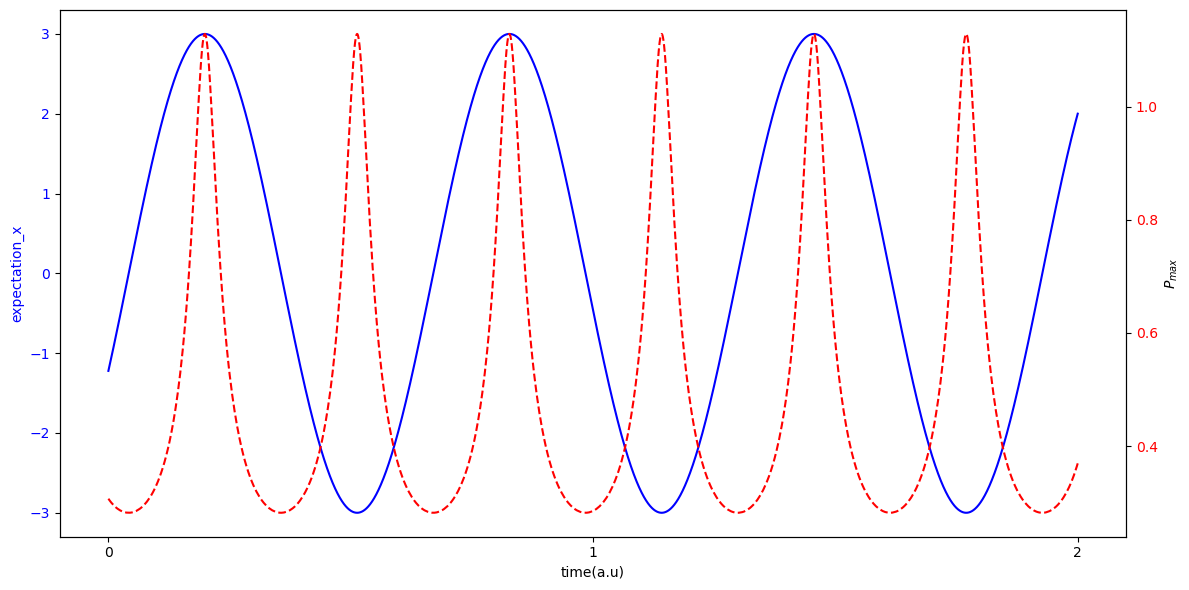

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize arrays to store the expectation values of position and peak probabilities
avgX = np.zeros(Nt)
peakProb = np.zeros(Nt)

# Define the time points
t = np.linspace(0, 2, Nt)

# Perform the time evolution
for i in range(Nt):
    I_half = I - np.dot(A,R) * (dt/2.)  #-- I(t + delta_t/2)
    R = R + np.dot(A,I_half) * dt       #-- R(t + delta_t)
    I = I_half - np.dot(A,R) * (dt/2.)  #-- I(t + delta_t)
    psi = R + 1j*I
    avgX[i] = avg_x(x, psi)
    peakProb[i] = np.max(np.abs(psi)**2)

# Plot the results
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.set_xlabel('time(a.u)')
ax1.set_ylabel('expectation_x', color='blue')
ax1.plot(t, avgX, label='Position Expectation Value', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xticks([0, 2, 1])
ax2 = ax1.twinx()
ax2.set_ylabel('$P_{max}$')
ax2.plot(t, peakProb, label='Peak Probability Density', linestyle='--', color='red')
ax2.tick_params(axis='y', labelcolor='red')

fig.tight_layout()
plt.show()


The expectation value $〈x〉$ as the function of the time is plotted with blue solid line. It follows a sinusoidal pattern like classical Harmonic Oscillator. The quantity $〈x〉$ provides a bridge between classical and quantum 
mechanics through the Ehrenfest theorem, which describes the
dynamics of physical observables governed by a set of relationships
very similar to classical equations of motion.

The value of Maximum probability density as a function of time is plotted red dashed line. The maximum value, $P_{max} $ , refers to the peak of the distribution, which is approximately at the center of the wavepacket. We can think of $P_{max} $ as a measure of how quickly the wavepacket broadens since it is inversely proportional to the width (roughly). $P_{max} $ starts from the peak value at t = 0 when the Gaussian is at its narrowest. It reaches the lowest value at the moment the center of the Gaussian is at x = 0, where the wavepacket is broadest, before recovering its peak value at the right end. The cycle repeats afterwards, so the period of $P_{max} $ is half the period of the SHO. Because the SDLF method preserves the norm, the peak values of $P_{max} $ stays constant.

### Ehrenfest Theorem Proof

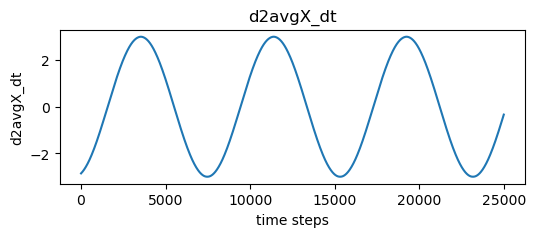

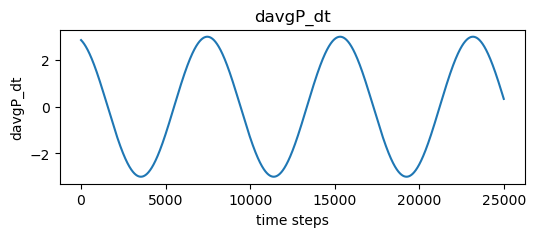

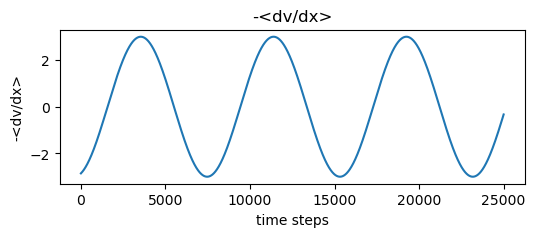

In [19]:
from scipy import integrate

# Define the function to calculate the time derivative of an array
def time_derivative(arr, dt):
    return (arr[2:] - arr[:-2]) / (2.0 * dt)

# Initialize arrays to store the expectation values of position and momentum
avgX = np.zeros(Nt)
avgP = np.zeros(Nt)
t=np.linspace(0,2,Nt+1)

# Perform the time evolution
for i in range(Nt):
    I_half = I - np.dot(A,R) * (dt/2.)  #-- I(t + delta_t/2)
    R = R + np.dot(A,I_half) * dt       #-- R(t + delta_t)
    I = I_half - np.dot(A,R) * (dt/2.)  #-- I(t + delta_t)
    psi = R + 1j*I
    avgX[i] = avg_x(x, psi)
    avgP[i] = avg_P(x, R, I)

# Calculate the time derivatives of the expectation values
davgX_dt = time_derivative(avgX, dt)
d2avgX_dt = time_derivative(time_derivative(avgX, dt),dt)
davgP_dt = time_derivative(avgP, dt)

LHS1 =d2avgX_dt
RHS1 = davgP_dt
# np.gradient(Vx) = x( by taking derivative of vx ) so exp(derivative of Vx) = exp(x) so rhs for second case is avg(x)
RHS2 = -avgX



# Plot the results
plt.figure(figsize=(6,2))
plt.title('d2avgX_dt')
plt.xlabel('time steps')
plt.ylabel('d2avgX_dt')
plt.plot(LHS1,label='$d2/dt <p>$')
plt.show()

plt.figure(figsize=(6,2))
plt.title('davgP_dt')
plt.plot(davgP_dt, label='$d/dt <p>$')
plt.xlabel('time steps')
plt.ylabel('davgP_dt')
plt.show()


plt.figure(figsize=(6,2))
plt.title('-<dv/dx>')
plt.xlabel('time steps')
plt.ylabel('-<dv/dx>')
plt.plot(-avgX, label='-V\'(x)')
plt.show()




As expected they are equal , there is phase difference of 90 degree between p and x as expected for SHO

The expectation values of position and momentum satisfy 

**$ m\frac{\partial^2 〈x〉}{\partial t^2} = \frac{d〈p〉}{dt} = -〈\frac{\partial V}{\partial x}〉 $**

The quantity 〈x〉 provides a bridge between classical and quantum mechanics through the Ehrenfest theorem, which describes the dynamics of physical observables governed by a set of relationships very similar to classical equations of motion. This equation is like Newton's second law with a force given by
$ F = −〈\frac{\partial V}{\partial x}〉$ . In given problem, $ V(x) = \frac{1}{2} x^2 $, thus F = −〈x〉. Substituting it into the above equation yields $〈x〉 = −A cos t$, just as observed earlier.